In [1]:
import pickle
import pandas as pd
import sys
import numpy as np

In [2]:
sys.path.append("../../code/")
sys.path.append("../code/")


from common_functions import tableau20blind, format_axes, latexify
from regional_average_contribution import contribution

In [3]:
out_overall = pickle.load(open('../../data/input/all_regions.pkl', 'r'))

In [4]:
mf_pred = pickle.load(open('../data/out_3_dd.pkl','r'))
knn_results = pickle.load(open('../data/knn_pred_all_homes.pkl','r'))

In [5]:
from sklearn.metrics import mean_squared_error

In [8]:
def compute_rmse_fraction(appliance, pred_df):
    region = "SanDiego"
    df = out_overall[region]
    #pred_df = mf_pred[appliance][appliance_feature][latent_factors]
    gt_df = df[pred_df.columns].ix[pred_df.index]
    if appliance=="hvac":
        start, stop=5,11
    else:
        start, stop=1,13
    aggregate_df = df.ix[pred_df.index][['aggregate_%d' %month for month in range(start, stop)]]

    aggregate_df.columns = gt_df.columns
    gt_fraction = gt_df.div(aggregate_df)*100
    pred_fraction = pred_df.div(aggregate_df)*100
    
    pred_fraction = pred_fraction.dropna()
    gt_fraction = gt_fraction.dropna()
    #print pred_fraction.describe()
    #print gt_fraction.describe()


    rms = np.sqrt(mean_squared_error(pred_fraction,gt_fraction))
    return rms

In [10]:
result = {'MF':{}}

In [11]:
best_combination = {}
for appliance, appliance_struct in mf_pred.iteritems():
    print appliance
    best_appliance=1000
    for appliance_feature, appliance_feature_struct in appliance_struct.iteritems():
        for latent_factors, appliance_df in appliance_struct[appliance_feature].iteritems():
            try:
                region = "SanDiego"
                df = out_overall[region]
                pred_df = mf_pred[appliance][appliance_feature][latent_factors]
                
                rms = compute_rmse_fraction(appliance, pred_df)

                if rms<best_appliance:

                    best_appliance=rms
                    best_combination[appliance]=(appliance_feature, latent_factors, rms)
            except:
                pass
    result['MF'][appliance]=best_appliance
            
print best_combination

fridge
hvac
{'fridge': ('occ', 9, 13.431200129690193), 'hvac': ('dd_11', 3, 14.022029756205505)}


In [10]:
def get_fhmm(appliance):
    count = 0
    for test_region in ["Austin"]:
        out = {}
        test_df = out_overall[test_region]
        #test_df=test_df[(test_df.full_agg_available==1)&(test_df.md_available==1)]
        
        if appliance=="hvac":
            start, stop=5, 11
        else:
            start, stop=1, 13
        out[appliance] = {}
        test_df_appliance=test_df.ix[test_df[['%s_%d' %(appliance,month) for month in range(start,stop)]].dropna().index]
        for test_home in test_df_appliance.index:
            try:
                #print test_home
                pred_df = pd.read_csv("/Users/nipunbatra/wiki-15min-fhmm-out/%s_%d.csv" %(test_region, test_home),index_col=0)
                pred_df_appliance = pred_df[appliance].ix[start:stop-1]
                gt_df_appliance = test_df.ix[test_home][['%s_%d' %(appliance, month) for month in range(start, stop)]]
                gt_df_appliance.index = pred_df_appliance.index
                error = ((pred_df_appliance-gt_df_appliance).abs()*100/gt_df_appliance)
                #error[error>100]=100
                #acc = 100-error
                out[appliance][test_home]=pred_df_appliance
            except:
                pass
    return pd.DataFrame(out[appliance]).T

In [11]:
for appliance in knn_results.keys():
    
    pred_df = get_fhmm(appliance)
    pred_df.columns = [appliance+"_"+str(x) for x in pred_df.columns]
    rmse_fraction = compute_rmse_fraction(appliance, pred_df)
    

    #rms = np.sqrt(mean_squared_error(gt_df, pred_df))
    result['FHMM'][appliance]=rmse_fraction

In [16]:
compute_rmse_fraction(appliance, pred_df)

             dw_1        dw_2        dw_3        dw_4        dw_5        dw_6  \
count  172.000000  172.000000  172.000000  172.000000  172.000000  172.000000   
mean    15.966040   16.086284   15.580529   14.861408   14.777384   13.711349   
std      3.978736    3.855541    3.258583    3.259070    3.168031    3.516272   
min      7.958924    6.951908    7.837711    7.875402    8.262268    6.304880   
25%     13.393285   13.836726   13.344178   12.922074   12.459659   11.247675   
50%     15.678826   15.627400   15.380421   14.696483   14.459801   13.479161   
75%     18.147080   18.396278   17.538216   16.318403   16.865908   15.771734   
max     30.964608   30.054686   25.413095   26.992424   23.249597   25.493696   

             dw_7        dw_8        dw_9       dw_10       dw_11       dw_12  
count  172.000000  172.000000  172.000000  172.000000  172.000000  172.000000  
mean    13.030885   12.790405   13.533130   14.708571   15.840556   16.166775  
std      3.817893    3.800274 

13.977017942863627

In [88]:
map_appliance = {'fridge':'Fridge','dw':'Dish\nwasher','mw':'Microwave','hvac':'HVAC','oven':'Oven','wm':'Washing\nmachine'}

In [89]:
#results_df[results_df>100]=100
#results_df=results_df.fillna(100)
results_df.index = [map_appliance[appliance] for appliance in results_df.index]
#results_df.plot(kind='bar', colors=tableau20blind[::2])

In [90]:
results_df = results_df.ix[['HVAC','Fridge','Oven','Dish\nwasher','Washing\nmachine','Microwave']]

In [20]:
results_df = results_df[['KNN','MF']]

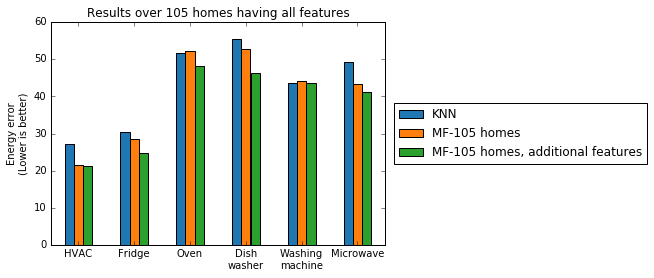

In [93]:
import matplotlib.pyplot as plt
results_df.plot(kind='bar',rot=0, colors=tableau20blind[::2])
lgd = plt.legend(loc='right', bbox_to_anchor=(1.8, 0.5))
plt.ylabel("Energy error\n(Lower is better)");
plt.title("Results over 105 homes having all features")
plt.savefig("../results/subset.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig("../results/subset.png",bbox_extra_artists=(lgd,), bbox_inches='tight')

Comparing MF with and without homes containing those features

In [23]:
best_combination

{'dw': ('occ', 1, 47.696584280069516),
 'fridge': ('occ_area', 2, 24.91311995551921),
 'hvac': ('rooms', 8, 21.29756141099046),
 'mw': ('occ', 2, 41.60195238757644),
 'oven': ('area_rooms', 8, 48.164684764512515),
 'wm': ('occ_rooms', 3, 43.7072363087808)}

In [31]:
pd.DataFrame(results)

,KNN,MF
dw,55.305178,47.696584
fridge,30.453563,24.913120
hvac,27.268441,21.297561
mw,49.199756,41.601952
oven,51.708601,48.164685
wm,43.735111,43.707236


In [100]:
for appliance in ['fridge','hvac','dw','mw','wm','oven']:
    mf_best = mf_pred[appliance][best_combination[appliance][0]][best_combination[appliance][1]]
    knn_best = knn_results[appliance]
    mf_best.columns = knn_best.columns
    common_index = np.intersect1d(mf_best.index, knn_best.index)
    mf_best = mf_best.ix[common_index]
    knn_best = knn_best.ix[common_index]
    knn_best_copy = knn_best.copy()
    mf_best_copy = mf_best.copy()
    max_two = (mf_best_copy.where(mf_best_copy > knn_best_copy, knn_best_copy).fillna(mf_best_copy))
    print appliance,100*((-mf_best+knn_best)/max_two).unstack().std()

fridge 57.3978457853
hvac 55.0774075892
dw 51.1713352881
mw 57.3493816955
wm 53.9492074301
oven 55.2763277251


In [ ]:
Calculating win/loss

In [97]:
o = {}
for appliance in ['fridge','hvac','dw','mw','wm','oven']:
    print appliance
    mf_best_pred = mf_pred[appliance][best_combination[appliance][0]][best_combination[appliance][1]]
    knn_best_pred = knn_results[appliance]
    mf_best_pred.columns = knn_best_pred.columns
    common_index = np.intersect1d(mf_best_pred.index, knn_best_pred.index)
    region = "Austin"
    df = out_overall[region]
    pred_df = mf_pred[appliance][appliance_feature][latent_factors]
    gt_df = df[pred_df.columns].ix[pred_df.index]
    mf_best_pred = mf_best_pred.ix[common_index]
    knn_best_pred = knn_best_pred.ix[common_index]
    error_mf = (gt_df-mf_best_pred).abs()
    error_knn = (gt_df-knn_best_pred).abs()
    win = (error_knn>error_mf).sum().sum()
    loss = (error_knn<error_mf).sum().sum()
   
    o[appliance]={'win':win, "loss":loss, "win/loss":win*1./loss,"win/(win_loss)":win*1./(win+loss)}

fridge
hvac
dw
mw
wm
oven


In [98]:
pd.DataFrame(o).T

,loss,win,win/(win_loss),win/loss
dw,288,408,0.586207,1.416667
fridge,423,393,0.481618,0.929078
hvac,277,293,0.514035,1.057762
mw,249,315,0.558511,1.265060
oven,179,181,0.502778,1.011173
wm,358,338,0.485632,0.944134


In [92]:
knn_best_pred.columns, mf_best_pred.columns

(Index([u'hvac_5', u'hvac_6', u'hvac_7', u'hvac_8', u'hvac_9', u'hvac_10'], dtype='object'),
 Index([u'hvac_5', u'hvac_6', u'hvac_7', u'hvac_8', u'hvac_9', u'hvac_10'], dtype='object'))

In [118]:
knn_best.median().mean()

51.70860070119945

In [119]:
appliance

'oven'